Ignacio Vellido Expósito

## Conclusiones

Entrenamos cada modelo con una partición train-test del 50/50, y obtenemos los mejores resultados con la arquitectura LSTM nº3, que corresponde a una única capa LSTM de 50 unidades con regularización a través de Early Stopping y sin Dropout, junto a un tamaño de batch de 200. 

También se obtiene una calidad muy similar en el modelo nº5, que incluye regularización de 0.2 y reduce el número de unidades a 25. Este modelo es más simple y rápido de entrenar, por lo que podría ser mejor candidato a ser el modelo final.

---

Gracias a la modificación de parámetros se deducen las siguientes conclusiones:

- Se aprecia un sobreajuste excesivamente rápido, a partir de la segunda época. Para paliarlo se reduce el learning rate del optimizador, de manera que podamos apreciar mejor la curva de aprendizaje.

- Efectos del batch size: Puesto que contamos con 50000 ejemplos de entrenamiento, el entrenamiento se alarga cuanto menor sea el tamaño del batch. 
Esto es debido a que no se aplica backpropagation hasta haber procesado el batch al completo, a costa de una peor convergencia y generalización (https://arxiv.org/abs/1609.04836).
En nuestro caso asignándole un valor de 200 nos da los mejores resultados en un tiempo de cómputo aceptable.

- Respecto al optimizador, no se dan cambios significativos entre RMSprop y Adam, aunque ligeramente superiores con este último.

- Los modelos feedforward se comportan bastante bien en este problema, probablemente por la representación en embedding que se ha utilizado (codifica la palabra y su posición como un vector denso).

- Como se comentó en el guiónIV, el entrenamiento de los modelos recurrentes resulta complejo. El manejo del batch_size y de unidades es lo más influyente en estas redes.

- Notamos la inclusión de Dropout ventajosa salvo cuando se incluye con un porcentaje alto (0.5), sobre todo en los modelos recurrentes.

- Se ve un decremento importante de generalización con arquitecturas RNN multicapa. Tal y como se aprecia en el resto de modelos, es posible obtener un 100% de precisión en entrenamiento con una sola capa recurrente, por lo que la inclusión vertical de más capas dificulta el aprendizaje (probablemente con regularización más agresiva se podría solucionar, pero no parece la mejor opción viendo que con modelos más simples se pueden obtener mejores resultados).

- A más alto el tamaño de salida del embedding peores resultados se obtienen. Los motivos de este hecho no quedan del todo claros.

### Resultados de accuracy en test

#### Feedforward models

1 | 0.8629

2 | 0.8575

3 | 0.8592

4 | 0.8705 --

5 | 0.8705

6 | 0.8543

7 | 0.8695

8 | 0.8670

9 | 0.8501

10 | 0.8597

11 | 0.8618

#### RNN

1 | 0.8001

2 | 0.8533

3 | 0.8222

4 | 0.7972

5 | 0.8080

6 | 0.8138

7 | 0.7905

8 | 0.8610 --

#### LSTM

1 | 0.8640

2 | 0.8681

3 | 0.8795 --

4 | 0.8734

5 | 0.8766

6 | 0.8644

7 | 0.8696

8 | 0.8735

9 | 0.8710

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam

from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix

# Set seed
seed = 111
np.random.seed(seed)

In [2]:
# Load the dataset
top_words = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)

# Get most frequent words
max_words = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [ ]:
# summarize size
print("Dataset a entrenar: {},{}".format(X.shape, y.shape))

# numero de clases
print("Clases: {}".format(np.unique(y)))

# ...

Dataset a entrenar: (50000,),(50000,)
Clases: [0 1]


In [3]:
def plot_history(history):
  acc = history.history["accuracy"]
  val_acc = history.history["val_accuracy"]

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  epochs = range(1, len(acc)+1)

  plt.plot(epochs, acc, "r", label="Training acc")
  plt.plot(epochs, val_acc, "b", label="Validation acc")
  plt.title("Training and validation accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.figure()

  plt.plot(epochs, loss, "r", label="Training loss")
  plt.plot(epochs, val_loss, "b", label="Validation loss")
  plt.title("Training and validation loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.figure()

  plt.show()

In [4]:
def evaluate_model(model, history):
  print(model.summary())

  print("Max Epochs: {}".format(epochs))
  print("Last epoch: {}".format(len(history.epoch)))
  print("Batch size: {}".format(batch_size))

  loss, acc = model.evaluate(X_test, y_test, verbose=0)  
  print("\nTest loss: {}".format(loss))
  print("Accuracy:  {}\n".format(acc))

  pred = model.predict(X_test)
  pred = (pred>.5)
  cm = confusion_matrix(y_test, pred)

  print(pd.DataFrame(cm))

  plot_history(history)

In [ ]:
# FEEDFORWARD MODEL

# Define model
model = Sequential([
  Embedding(top_words, 32, input_length=max_words),
  Flatten(),
  Dense(256, activation="relu"),
  Dropout(0.2),
  Dense(128, activation="relu"),
  Dropout(0.5),
  Dense(1, activation="sigmoid"),
])

model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

# Parameters
epochs = 7
batch_size = 200

# Train model
history = model.fit(
              X_train, y_train,
              validation_data=(X_test,y_test),
              epochs=epochs,
              batch_size=batch_size,
              callbacks=[EarlyStopping(monitor='val_accuracy', 
                                       patience=3)],
              verbose=0
          )

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
flatten_9 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)               4096256   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                

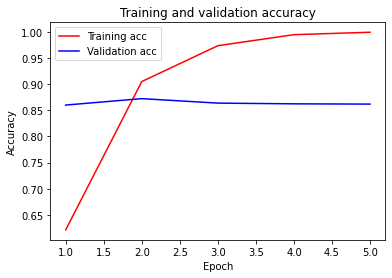

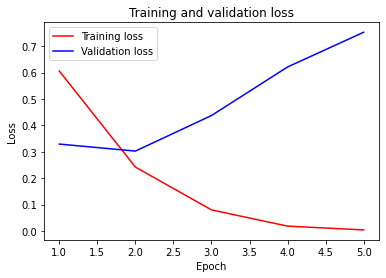

<Figure size 432x288 with 0 Axes>

In [ ]:
# 11
evaluate_model(model, history)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 500, 64)           320000    
_________________________________________________________________
flatten_8 (Flatten)          (None, 32000)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               8192256   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                

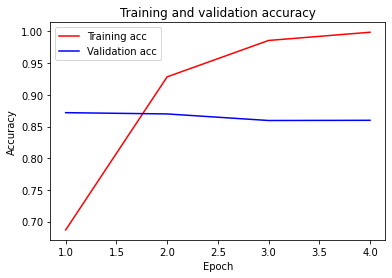

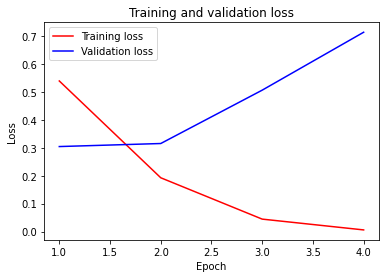

<Figure size 432x288 with 0 Axes>

In [ ]:
# 10
evaluate_model(model, history)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 500, 64)           320000    
_________________________________________________________________
flatten_7 (Flatten)          (None, 32000)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               8192256   
_________________________________________________________________
dense_17 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 257       
Total params: 8,578,305
Trainable params: 8,578,305
Non-trainable params: 0
____________________________________________

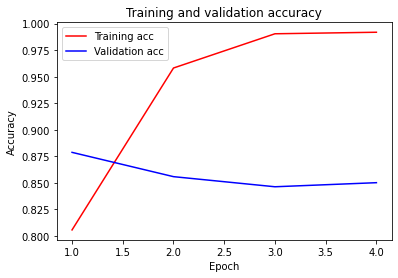

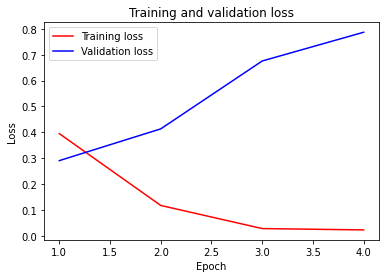

<Figure size 432x288 with 0 Axes>

In [ ]:
# 9- Modelo complejo con Dropout
evaluate_model(model, history)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 64)           320000    
_________________________________________________________________
flatten_5 (Flatten)          (None, 32000)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 128004    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 5         
Total params: 448,009
Trainable params: 448,009
Non-trainable params: 0
_________________________________________________________________
None
Max Epochs: 20
Last epoch: 4
Batch size: 32

Test loss: 0.43148621916770935
Accuracy:  0.8670799732208252

       0      1
0  10590   1910
1   1413  11087


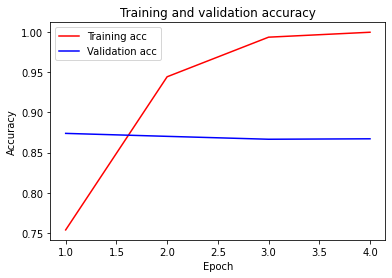

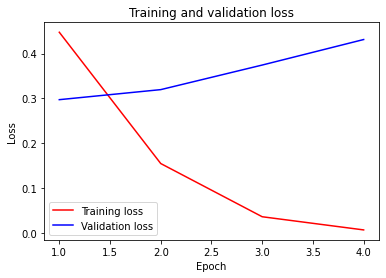

<Figure size 432x288 with 0 Axes>

In [ ]:
# 8- Aumentando embedding
evaluate_model(model, history)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 8)            40000     
_________________________________________________________________
flatten_4 (Flatten)          (None, 4000)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 16004     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 5         
Total params: 56,009
Trainable params: 56,009
Non-trainable params: 0
_________________________________________________________________
None
Max Epochs: 20
Last epoch: 4
Batch size: 32

Test loss: 0.3567139506340027
Accuracy:  0.8695200085639954

       0      1
0  10719   1781
1   1481  11019


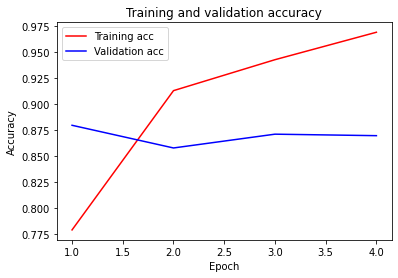

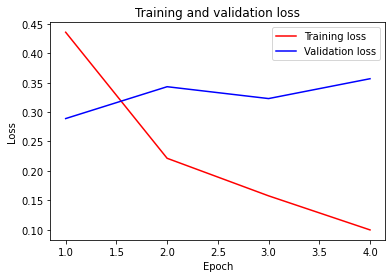

<Figure size 432x288 with 0 Axes>

In [ ]:
# 7
evaluate_model(model, history)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 8)            40000     
_________________________________________________________________
flatten_3 (Flatten)          (None, 4000)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                64016     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 104,033
Trainable params: 104,033
Non-trainable params: 0
_________________________________________________________________
None
Max Epochs: 20
Last epoch: 4
Batch size: 32

Test loss: 0.4621508717536926
Accuracy:  0.8543999791145325

       0      1
0  11197   1303
1   2337  10163


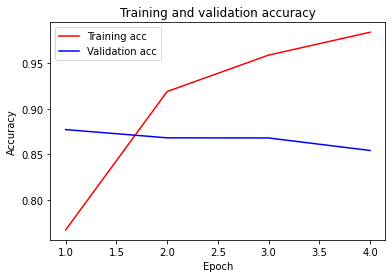

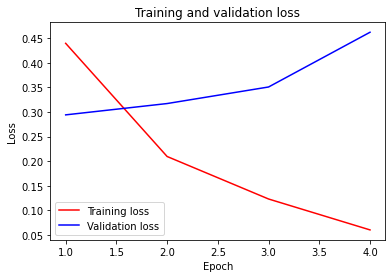

<Figure size 432x288 with 0 Axes>

In [ ]:
# 6- Comprobando si bajando el tamaño del embedding empeora test
evaluate_model(model, history)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 16)           80000     
_________________________________________________________________
flatten_2 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                128016    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 208,033
Trainable params: 208,033
Non-trainable params: 0
_________________________________________________________________
None
Max Epochs: 20
Last epoch: 5
Batch size: 128

Test loss: 0.38631895184516907
Accuracy:  0.8705199956893921

       0      1
0  10720   1780
1   1457  11043


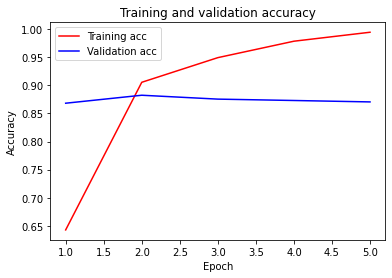

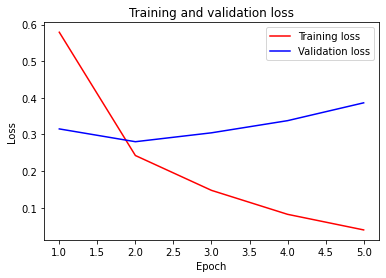

<Figure size 432x288 with 0 Axes>

In [ ]:
# 5- Reduciendo batch size
evaluate_model(model, history)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 16)           80000     
_________________________________________________________________
flatten_2 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                128016    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 208,033
Trainable params: 208,033
Non-trainable params: 0
_________________________________________________________________
None
Max Epochs: 20
Last epoch: 5
Batch size: 128

Test loss: 0.38631895184516907
Accuracy:  0.8705199956893921

       0      1
0  10720   1780
1   1457  11043


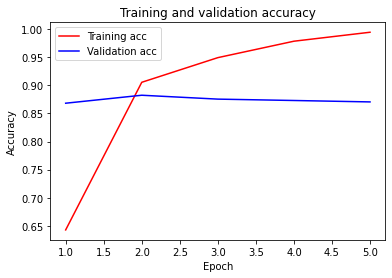

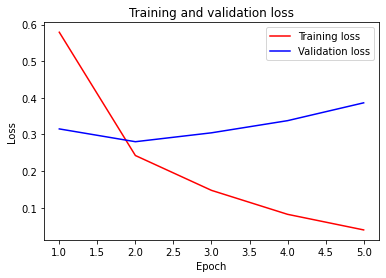

<Figure size 432x288 with 0 Axes>

In [ ]:
# 4
evaluate_model(model, history)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 16)           80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                512064    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 596,289
Trainable params: 596,289
Non-trainable params: 0
_________________________________________________________________
None
Max Epochs: 20
Last epoch: 4
Batch size: 128

Test loss: 0.5435996651649475
Accuracy:  0.8592399954795837

  

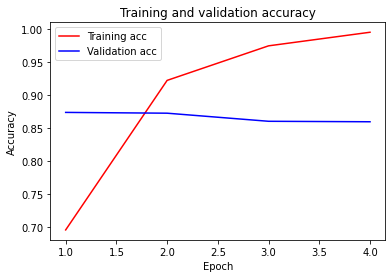

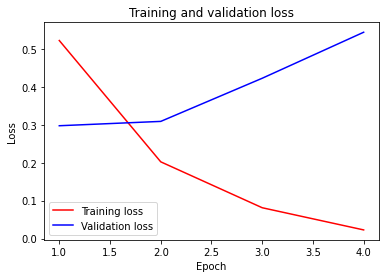

<Figure size 432x288 with 0 Axes>

In [ ]:
# 3
evaluate_model(model, history)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 32)           160000    
_________________________________________________________________
flatten (Flatten)            (None, 16000)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2048128   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 2,224,769
Trainable params: 2,224,769
Non-trainable params: 0
_________________________________________________________________
None
Max Epochs: 20
Last epoch: 4
Batch size: 128

Test loss: 0.7030827403068542
Accuracy:  0.8575999736785889



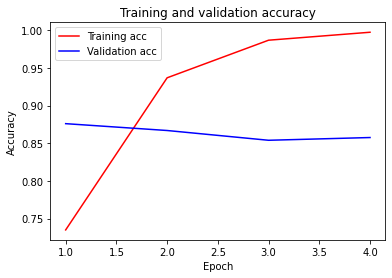

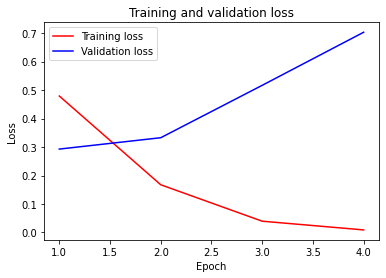

<Figure size 432x288 with 0 Axes>

In [ ]:
# 2- Menos unidades, más profundo
evaluate_model(model, history)

# Intentando aplazar el overfitting

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
flatten_3 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 250)               4000250   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 251       
Total params: 4,160,501
Trainable params: 4,160,501
Non-trainable params: 0
_________________________________________________________________
None
Epochs:     20
Batch size: 128

Test loss: 0.6099019050598145
Accuracy:  0.8629599809646606

       0      1
0  10803   1697
1   1729  10771


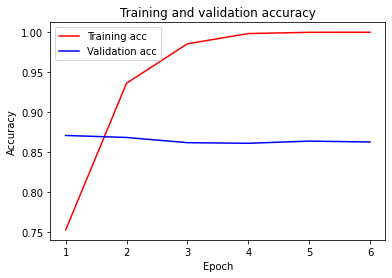

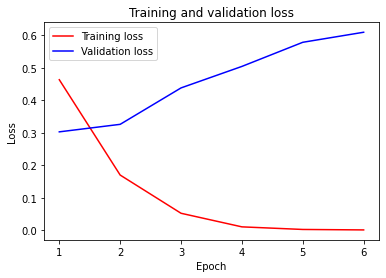

<Figure size 432x288 with 0 Axes>

In [ ]:
# 1- Modelo inicial
evaluate_model(model, history)

# Overfitting instantáneo

In [ ]:
# RNN

# Define model
model = Sequential([
  Embedding(top_words, 32, input_length=max_words),
  SimpleRNN(50),
  Dropout(0.25),
  Dense(1, activation="sigmoid"),
])

lr = 5e-4

model.compile(
    loss="binary_crossentropy",
    # optimizer="rmsprop",
    # optimizer="adam",
    optimizer=Adam(learning_rate=lr),
    metrics=["accuracy"]
)

# Parameters
epochs = 15
batch_size = 200

# Train model
history = model.fit(
              X_train, y_train,
              validation_data=(X_test,y_test),
              epochs=epochs,
              batch_size=batch_size,
              callbacks=[EarlyStopping(monitor='val_accuracy', 
                                       patience=5)],
              verbose=0
          )

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 500, 32)           160000    
_________________________________________________________________
simple_rnn_12 (SimpleRNN)    (None, 50)                4150      
_________________________________________________________________
dropout_17 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 51        
Total params: 164,201
Trainable params: 164,201
Non-trainable params: 0
_________________________________________________________________
None
Max Epochs: 15
Last epoch: 9
Batch size: 200

Test loss: 0.37714293599128723
Accuracy:  0.8610000014305115

       0      1
0  10217   2283
1   1192  11308


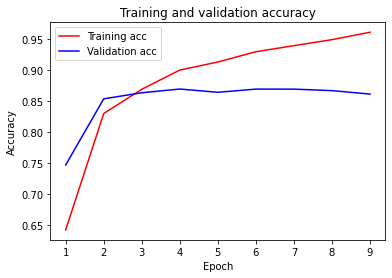

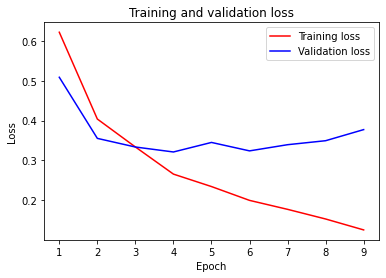

<Figure size 432x288 with 0 Axes>

In [ ]:
# 8- lr=0.005
evaluate_model(model, history)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 500, 32)           160000    
_________________________________________________________________
simple_rnn_10 (SimpleRNN)    (None, 50)                4150      
_________________________________________________________________
dropout_15 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 51        
Total params: 164,201
Trainable params: 164,201
Non-trainable params: 0
_________________________________________________________________
None
Max Epochs: 15
Last epoch: 9
Batch size: 200

Test loss: 0.6731500029563904
Accuracy:  0.7905600070953369

      0      1
0  9758   2742
1  2494  10006


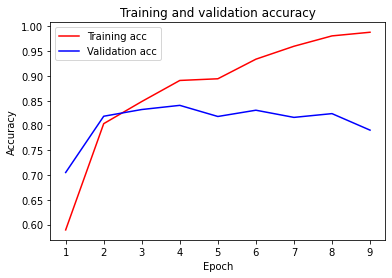

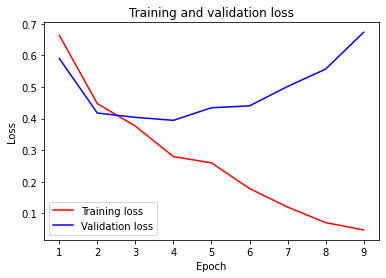

<Figure size 432x288 with 0 Axes>

In [ ]:
# 7
evaluate_model(model, history)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 500, 32)           160000    
_________________________________________________________________
simple_rnn_9 (SimpleRNN)     (None, 100)               13300     
_________________________________________________________________
dropout_14 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 101       
Total params: 173,401
Trainable params: 173,401
Non-trainable params: 0
_________________________________________________________________
None
Max Epochs: 15
Last epoch: 9
Batch size: 200

Test loss: 0.6350507140159607
Accuracy:  0.8138800263404846

      0      1
0  9700   2800
1  1853  10647


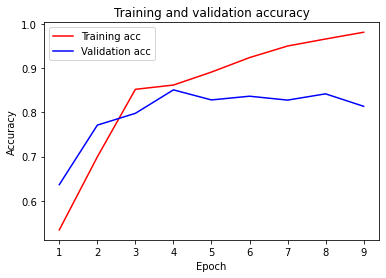

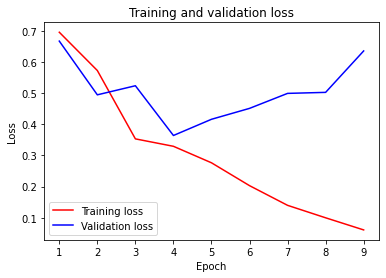

<Figure size 432x288 with 0 Axes>

In [ ]:
# 6- Usando ADAM
evaluate_model(model, history)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 500, 32)           160000    
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 500, 25)           1450      
_________________________________________________________________
dropout_11 (Dropout)         (None, 500, 25)           0         
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 25)                1275      
_________________________________________________________________
dropout_12 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 26        
Total params: 162,751
Trainable params: 162,751
Non-trainable params: 0
_______________________________________________

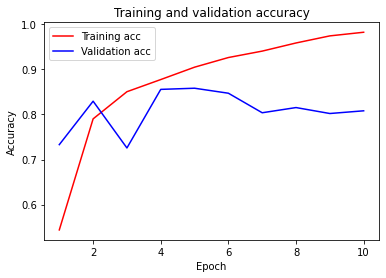

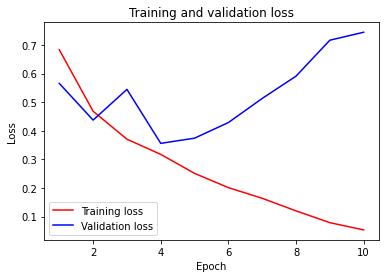

<Figure size 432x288 with 0 Axes>

In [ ]:
# 5
evaluate_model(model, history)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 500, 32)           160000    
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 500, 50)           4150      
_________________________________________________________________
dropout_9 (Dropout)          (None, 500, 50)           0         
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 50)                5050      
_________________________________________________________________
dropout_10 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 51        
Total params: 169,251
Trainable params: 169,251
Non-trainable params: 0
_______________________________________________

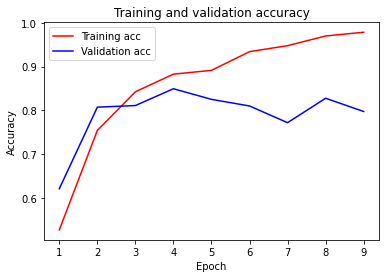

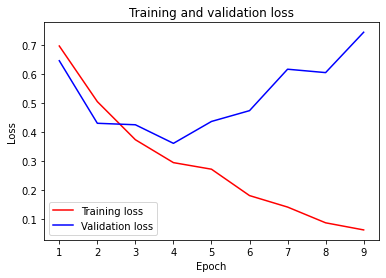

<Figure size 432x288 with 0 Axes>

In [ ]:
# 4- Más profunda
evaluate_model(model, history)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 500, 64)           320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 50)                5750      
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 51        
Total params: 325,801
Trainable params: 325,801
Non-trainable params: 0
_________________________________________________________________
None
Max Epochs: 15
Last epoch: 8
Batch size: 200

Test loss: 0.5887460112571716
Accuracy:  0.8222399950027466

       0      1
0  10216   2284
1   2160  10340


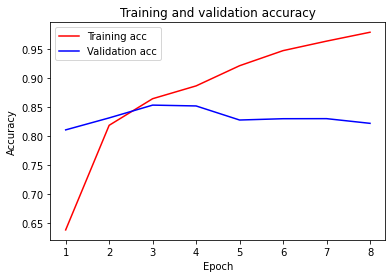

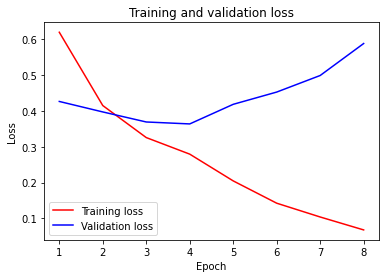

<Figure size 432x288 with 0 Axes>

In [ ]:
# 3
evaluate_model(model, history)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 500, 32)           160000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 50)                4150      
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 51        
Total params: 164,201
Trainable params: 164,201
Non-trainable params: 0
_________________________________________________________________
None
Max Epochs: 7
Last epoch: 7
Batch size: 200

Test loss: 0.391927570104599
Accuracy:  0.8533599972724915

       0      1
0  10960   1540
1   2126  10374


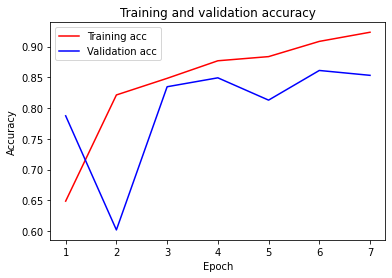

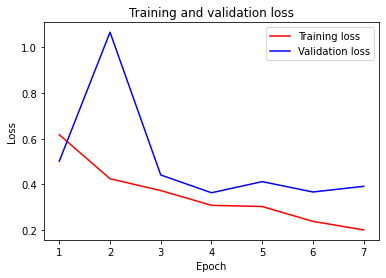

<Figure size 432x288 with 0 Axes>

In [ ]:
# 2- Regularización
evaluate_model(model, history)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 50)                4150      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 51        
Total params: 164,201
Trainable params: 164,201
Non-trainable params: 0
_________________________________________________________________
None
Epochs:     20
Batch size: 128

Test loss: 0.6016235947608948
Accuracy:  0.8001599907875061

      0      1
0  9809   2691
1  2305  10195


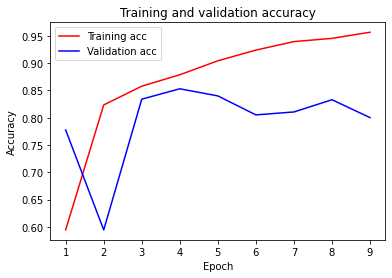

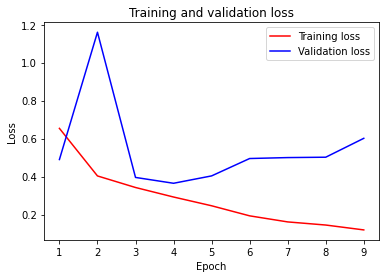

<Figure size 432x288 with 0 Axes>

In [ ]:
# 1- Inicial
evaluate_model(model, history)

In [5]:
# LSTM

# Define model
model = Sequential([
  Embedding(top_words, 128, input_length=max_words),
  # LSTM(50, return_sequences=True),
  # Dropout(0.2),
  LSTM(50),
  # Dropout(0.2),
  Dense(1, activation="sigmoid"),
])

lr = 5e-4

model.compile(
    loss="binary_crossentropy",
    # optimizer="rmsprop",
    # optimizer="adam",
    optimizer=Adam(learning_rate=lr),
    metrics=["accuracy"]
)

# Parameters
epochs = 20
batch_size = 200

# Train model
history = model.fit(
              X_train, y_train,
              validation_data=(X_test,y_test),
              epochs=epochs,
              batch_size=batch_size,
              callbacks=[EarlyStopping(monitor='val_accuracy', 
                                       patience=3)],
              verbose=0
          )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 128)          640000    
_________________________________________________________________
lstm (LSTM)                  (None, 50)                35800     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 675,851
Trainable params: 675,851
Non-trainable params: 0
_________________________________________________________________
None
Max Epochs: 20
Last epoch: 7
Batch size: 200

Test loss: 0.3361426591873169
Accuracy:  0.8710799813270569

       0      1
0  11141   1359
1   1864  10636


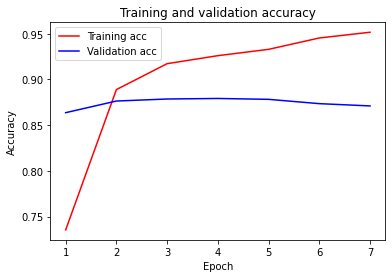

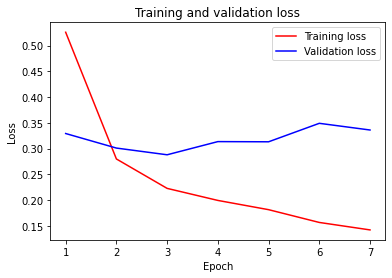

<Figure size 432x288 with 0 Axes>

In [6]:
# 9- Más tamaño de salida en embedding
evaluate_model(model, history)

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 500, 32)           160000    
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                16600     
_________________________________________________________________
dropout_22 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 51        
Total params: 176,651
Trainable params: 176,651
Non-trainable params: 0
_________________________________________________________________
None
Max Epochs: 20
Last epoch: 6
Batch size: 150

Test loss: 0.3277852237224579
Accuracy:  0.8735600113868713

       0      1
0  11332   1168
1   1993  10507


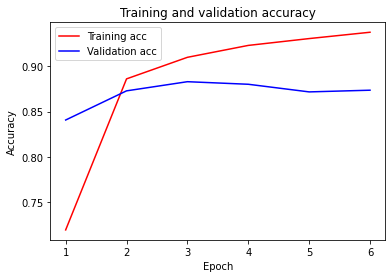

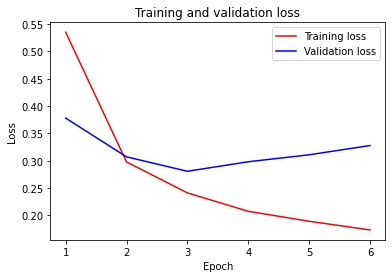

<Figure size 432x288 with 0 Axes>

In [ ]:
# 8
evaluate_model(model, history)

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 500, 32)           160000    
_________________________________________________________________
lstm_6 (LSTM)                (None, 500, 32)           8320      
_________________________________________________________________
dropout_20 (Dropout)         (None, 500, 32)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_21 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 33        
Total params: 176,673
Trainable params: 176,673
Non-trainable params: 0
_______________________________________________

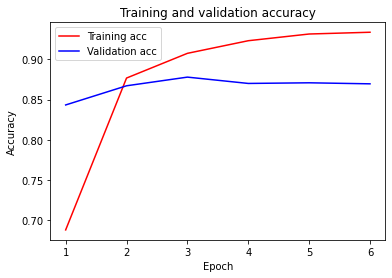

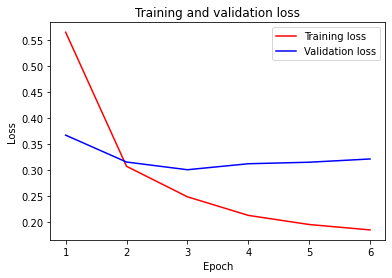

<Figure size 432x288 with 0 Axes>

In [ ]:
# 7
evaluate_model(model, history)

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 500, 32)           160000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 500, 16)           3136      
_________________________________________________________________
lstm_5 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dropout_19 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 17        
Total params: 165,265
Trainable params: 165,265
Non-trainable params: 0
_________________________________________________________________
None
Max Epochs: 20
Last epoch: 7
Batch size: 200

Test loss: 0.3404155373573303
Accuracy:  0.8644400238990784

 

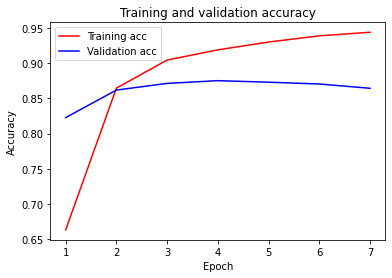

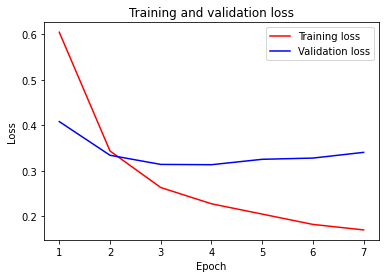

<Figure size 432x288 with 0 Axes>

In [ ]:
# 6
evaluate_model(model, history)

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 500, 32)           160000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 25)                5800      
_________________________________________________________________
dropout_18 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 26        
Total params: 165,826
Trainable params: 165,826
Non-trainable params: 0
_________________________________________________________________
None
Max Epochs: 20
Last epoch: 9
Batch size: 200

Test loss: 0.3272388279438019
Accuracy:  0.8766400218009949

       0      1
0  11087   1413
1   1671  10829


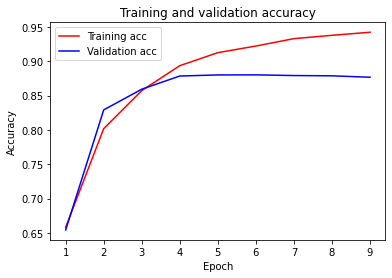

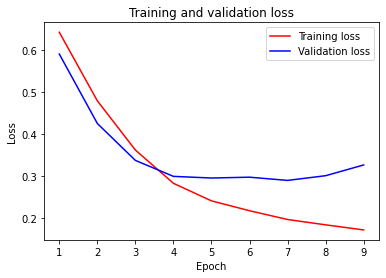

<Figure size 432x288 with 0 Axes>

In [ ]:
# 5- Dropout
evaluate_model(model, history)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 500, 32)           160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 25)                5800      
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 26        
Total params: 165,826
Trainable params: 165,826
Non-trainable params: 0
_________________________________________________________________
None
Max Epochs: 20
Last epoch: 8
Batch size: 200

Test loss: 0.3363225758075714
Accuracy:  0.8734800219535828

       0      1
0  10850   1650
1   1513  10987


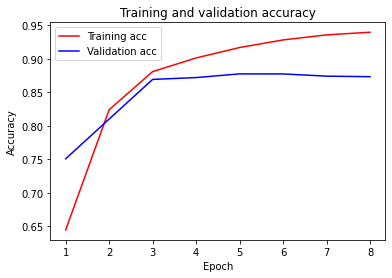

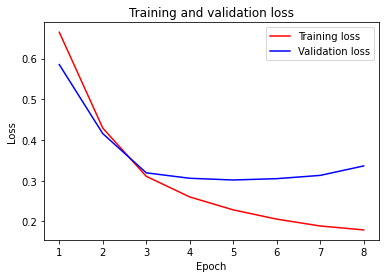

<Figure size 432x288 with 0 Axes>

In [ ]:
# 4- Menos unidades
evaluate_model(model, history)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 500, 32)           160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                16600     
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 51        
Total params: 176,651
Trainable params: 176,651
Non-trainable params: 0
_________________________________________________________________
None
Max Epochs: 20
Last epoch: 6
Batch size: 200

Test loss: 0.29819929599761963
Accuracy:  0.8795999884605408

       0      1
0  11212   1288
1   1722  10778


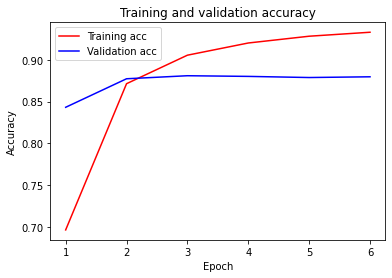

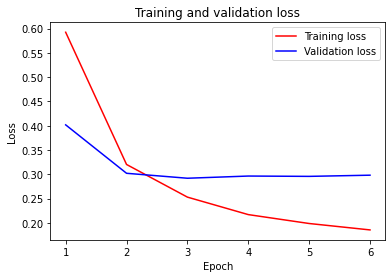

<Figure size 432x288 with 0 Axes>

In [ ]:
# 3- lr=0.005
evaluate_model(model, history)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 500, 32)           160000    
_________________________________________________________________
lstm (LSTM)                  (None, 50)                16600     
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 51        
Total params: 176,651
Trainable params: 176,651
Non-trainable params: 0
_________________________________________________________________
None
Max Epochs: 20
Last epoch: 8
Batch size: 200

Test loss: 0.39632633328437805
Accuracy:  0.8681600093841553

       0      1
0  10496   2004
1   1292  11208


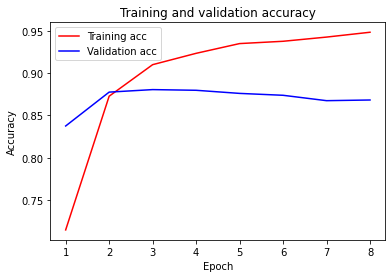

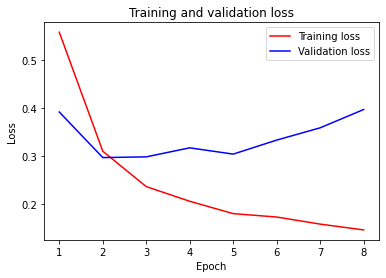

<Figure size 432x288 with 0 Axes>

In [ ]:
# 2- Adam
evaluate_model(model, history)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
lstm (LSTM)                  (None, 50)                16600     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 51        
Total params: 176,651
Trainable params: 176,651
Non-trainable params: 0
_________________________________________________________________
None
Epochs:     20
Batch size: 128

Test loss: 0.40396448969841003
Accuracy:  0.8640400171279907

       0      1
0  11148   1352
1   2047  10453


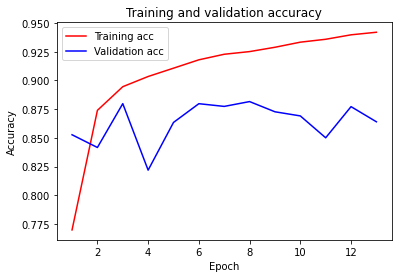

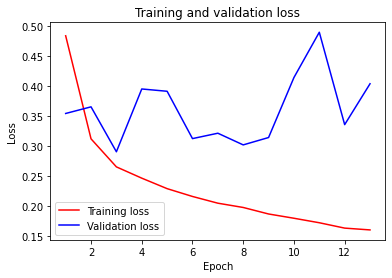

<Figure size 432x288 with 0 Axes>

In [ ]:
# 1
evaluate_model(model, history)